In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
from collections import Counter
import matplotlib.pyplot as plt 
import pandas as pd
import math
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import os

from pycocotools.coco import COCO

In [2]:
DATA_PATH = Path('data')
ANNOT_PATH = Path(DATA_PATH/'annotations')

### COCO utils

In [3]:
def get_annot_index(annot_path, dataset='train', year=2017):
    annot_file = annot_path/f'captions_{dataset}{year}.json'
    return COCO(annot_file)

In [4]:
def get_instance_index(annot_path, dataset='train', year=2017):
    annot_file = annot_path/f'instances_{dataset}{year}.json'
    return COCO(annot_file)

In [5]:
def get_caption_index(annot_path, dataset='train', year=2017):
    annot_file = annot_path/f'captions_{dataset}{year}.json'
    return COCO(annot_file)

### Image utils

In [6]:
def read_image(datapath, filename, dataset='train', year=2017):
    im = cv2.imread(f'{str(datapath)}/{dataset}{year}/{filename}')
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [7]:
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

### Example image transformations

In [8]:
coco = get_caption_index(ANNOT_PATH)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


#### Original image

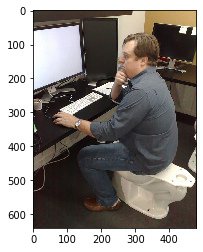

In [21]:
all_annot_ids = list(coco.anns.keys())
annot_id = all_annot_ids[33]  # random annot ID
ann_id = all_annot_ids[annot_id]
caption = coco.anns[ann_id]['caption']
img_id = coco.anns[ann_id]['image_id']
filename = coco.loadImgs(img_id)[0]['file_name']
img = read_image(DATA_PATH, filename)
plt.imshow(img); plt.show()

#### Center crop

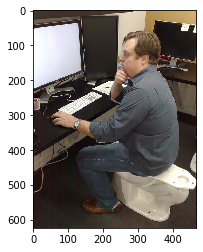

In [23]:
plt.imshow(center_crop(img), cmap='gray'); plt.show()

#### Random crop

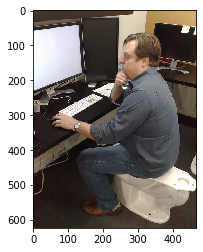

In [24]:
# resize desforms the image a bit
# note that by resizing to a larger number and random cropping we are doing horizontal and vertical translations
# we should try just center cropping the image instead of resizing
plt.imshow(random_crop(img), cmap='gray'); plt.show()

#### Rotation

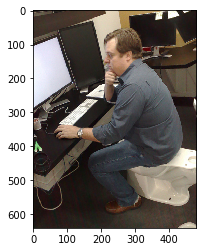

In [44]:
rdeg = (np.random.random()-.50)*30
im_rot = rotate_cv(img, rdeg)
plt.imshow(im_rot, cmap='gray'); plt.show()

#### Flip

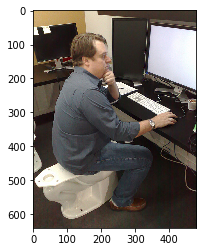

In [46]:
plt.imshow(np.fliplr(img), cmap='gray'); plt.show()